# Evaluation

**TODO**:
- Add $R^2$ values to evaluation metrics
- Add speed estimation

## Imports

In [1]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import plotly.graph_objs as go
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from pathlib import Path

## Global Variables

In [3]:
COLAB = True

In [4]:
ROOT_DIR_PATH = os.path.abspath('..')

if COLAB:

  from google.colab import drive
  drive.mount('/content/drive')

  ROOT_DIR_PATH = os.path.abspath('drive/MyDrive/Spatial_Finance_Transport/')

TRUE_AADT_PATH = os.path.join(ROOT_DIR_PATH, 'data/ground_truth_data/aadt/')

PRED_AADT_PATH = os.path.join(ROOT_DIR_PATH, 'data/predicted/aadt/')

TRUE_GHG_PATH = os.path.join(ROOT_DIR_PATH, 'data/ground_truth_data/ghg_emissions/')

PRED_GHG_PATH = os.path.join(ROOT_DIR_PATH, 'data/predicted/ghg_emissions/')

TRUE_TRAFFIC_COUNT_PATH = os.path.join(ROOT_DIR_PATH, 'data/ground_truth_data/traffic_counts/')

PRED_TRAFFIC_COUNT_PATH = os.path.join(ROOT_DIR_PATH, 'data/predicted/traffic_counts/')

TRUE_SPEED_PATH = os.path.join(ROOT_DIR_PATH, 'data/ground_truth_data/speed_data/')

PRED_SPEED_PATH = os.path.join(ROOT_DIR_PATH, 'data/predicted/speed/')

PLOT_DIR = os.path.join(ROOT_DIR_PATH, 'data/predicted/results/plots/')

METRICS_DIR = os.path.join(ROOT_DIR_PATH, 'data/predicted/results/metrics/')

AROADS_METRICS_DIR = os.path.join(ROOT_DIR_PATH, '/ARoads/data/predicted/results/metrics/')

MINOR_ROADS_METRICS_DIR = os.path.join(ROOT_DIR_PATH, '/minorRoads/data/predicted/results/metrics/')

ADMIN_DIR = os.path.join(ROOT_DIR_PATH, 'admin/')

YOLOV5_RESULTS_DIR = os.path.join(ROOT_DIR_PATH, 'models/object_detection_models/results.csv')

CHOSEN_COUNT_SITES = [('Luton', 'M1/2557A', 'M1/2557B'), ('Hounslow', 'M4/2188A', 'M4/2188B'), ('Enfield', 'M25/5441A', 'M25/5441B'), 
                      ('Blackburn with Darwen', '30361033', '30361032'), ('Havering', 'M25/5790A', 'M25/5790B'), ('Trafford', 'M60/9083A', 'M60/9086B')]

Mounted at /content/drive


In [5]:
NORMALISE_DICT = {
    'Total_N15': 'Total Volume',
    'Small_N15': '0-520cm',
    'Medium_N15': '521-660cm',
    'Large_N15': '661-1160cm',
    'Very Large_N15': '1160+cm'
}

MODE = 'max' # from max, median, mean, no_vehicle_type, no_speed_data

## Helper Functions

In [6]:
def get_files_by_prefix(directory, prefix):
    """
    Returns a list of file paths in a directory that match the start of a string.
    
    Args:
    directory (str): the path to the directory to search in.
    prefix (str): the prefix of the file names to match.
    
    Returns:
    A list of file paths that match the specified prefix.
    """
    matching_files = []
    for filename in os.listdir(directory):
        if prefix in filename:
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                matching_files.append(file_path)
    return matching_files

In [7]:
def match_before_underscore_or_space(str1, str2):
    """Checks if two strings match in elements before the first underscore or space.

    Args:
        str1 (str): The first string.
        str2 (str): The second string.

    Returns:
        bool: True if the strings match in elements before the first underscore or space, False otherwise.
    """
    # Find the index of the first underscore or space in both strings
    index1 = min(str1.find("_"), str1.find(" ")) if (str1.find("_") != -1 and str1.find(" ") != -1) else max(str1.find("_"), str1.find(" "))
    index2 = min(str2.find("_"), str2.find(" ")) if (str2.find("_") != -1 and str2.find(" ") != -1) else max(str2.find("_"), str2.find(" "))
    
    # Extract the substring before the first underscore or space from both strings
    sub_str1 = str1[:index1] if index1 >= 0 else str1
    sub_str2 = str2[:index2] if index2 >= 0 else str2
    
    # Compare the two substrings
    return sub_str1 == sub_str2

In [8]:
def plot_results(file='path/to/results.csv', dir=''):
    # Plot training results.csv. Usage: from utils.plots import *; plot_results('path/to/results.csv')
    save_dir = Path(file).parent if file else Path(dir)
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    files = list(save_dir.glob('results*.csv'))
    assert len(files), f'No results.csv files found in {save_dir.resolve()}, nothing to plot.'
    for fi, f in enumerate(files):
        try:
            data = pd.read_csv(f)
            s = [x.strip() for x in data.columns]
            x = data.values[:, 0]
            for i, j in enumerate([1, 2, 3, 4, 5, 8, 9, 10, 6, 7]):
                y = data.values[:, j]
                # y[y == 0] = np.nan  # don't show zero values
                ax[i].plot(x, y, marker='.', label=f.stem, linewidth=2, markersize=8)
                ax[i].set_title(s[j], fontsize=12)
                # if j in [8, 9, 10]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except Exception as e:
            LOGGER.info(f'Warning: Plotting error for {f}: {e}')
    ax[1].legend()
    fig.savefig(save_dir / 'results.png', dpi=200)
    plt.close()

## AADT

### Load true data

In [9]:
df_true_aadt_list = []

prefix = 'all_motor_vehicles'

true_aadt_paths = get_files_by_prefix(TRUE_AADT_PATH, prefix)

for true_aadt_path in true_aadt_paths:
  df = pd.read_csv(true_aadt_path)

  print(df.iloc[0]['Local Authority'])

  df_true_aadt_list.append(df)

print("df list length: {}".format(len(df_true_aadt_list)))
df_true_aadt_list[0].head()

Luton
Hounslow
Enfield
Trafford
Havering
Blackburn with Darwen
df list length: 6


,Unnamed: 0,year,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,Local Authority
0,0,2005,47844.0,399.0,6977.0,9520.0,64372.0,Luton
1,1,2006,43416.0,337.0,7801.0,8357.0,60154.0,Luton
2,2,2007,36825.0,446.0,6764.0,8823.0,52195.0,Luton
3,3,2008,47108.0,412.0,6348.0,8245.0,62348.0,Luton
4,4,2009,42067.0,314.0,6546.0,7832.0,54596.0,Luton


### Load predicted data

In [10]:
df_pred_aadt_list = []

prefix = 'aadt_'

pred_aadt_paths = get_files_by_prefix(PRED_AADT_PATH, prefix)

for pred_aadt_path in pred_aadt_paths:
  df = pd.read_csv(pred_aadt_path)

  print(df.iloc[0]['image_id'])

  df_pred_aadt_list.append(df)

print("df list length: {}".format(len(df_pred_aadt_list)))
df_pred_aadt_list[0].head()

hounslow_m4_2188b
havering_m25_5790b
blackburn_30361032
havering_m25_5790a
trafford_m60_9083a
luton_m1_2557a
trafford_m60_9086b
hounslow_m4_2188a
blackburn_30361033
luton_m1_2557b
df list length: 10


,image_id,aadt,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs
0,hounslow_m4_2188b,84389.18,74569.9,696.55,12275.62,3413.69


### Average predictions

In [11]:
for df_pred_aadt_1 in df_pred_aadt_list:

  image_id_1 = df_pred_aadt_1.iloc[0]['image_id']

  aadt_1 = df_pred_aadt_1.iloc[0]['aadt']

  for df_pred_aadt_2 in df_pred_aadt_list:

    image_id_2 = df_pred_aadt_2.iloc[0]['image_id']

    aadt_2 = df_pred_aadt_2.iloc[0]['aadt']

    if match_before_underscore_or_space(image_id_1, image_id_2) and (image_id_1 != image_id_2):

      print("found match for: {}".format(image_id_1))

      mean_aadt = ( aadt_1 + aadt_2 ) / 2

      df_pred_aadt_1['mean_aadt'] = mean_aadt
      df_pred_aadt_2['mean_aadt'] = mean_aadt

df_pred_aadt_list[0].head()

found match for: hounslow_m4_2188b
found match for: havering_m25_5790b
found match for: blackburn_30361032
found match for: havering_m25_5790a
found match for: trafford_m60_9083a
found match for: luton_m1_2557a
found match for: trafford_m60_9086b
found match for: hounslow_m4_2188a
found match for: blackburn_30361033
found match for: luton_m1_2557b


,image_id,aadt,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,mean_aadt
0,hounslow_m4_2188b,84389.18,74569.9,696.55,12275.62,3413.69,79407.84


### Add true aadt column to predicted

In [12]:
df_aadt = pd.DataFrame()

for df_true_aadt in df_true_aadt_list:

  la_name = df_true_aadt.iloc[0]['Local Authority']

  true_aadt = df_true_aadt.loc[df_true_aadt['year'] == 2018]['all_motor_vehicles'].values

  for df_pred_aadt in df_pred_aadt_list:

    image_id = df_pred_aadt.iloc[0]['image_id']

    if match_before_underscore_or_space(la_name.lower(), image_id):

      print("found match for: {}".format(image_id))

      df_pred_aadt['true_aadt'] = true_aadt

      df_aadt = pd.concat([df_aadt, df_pred_aadt], ignore_index=True)

df_aadt

found match for: luton_m1_2557a
found match for: luton_m1_2557b
found match for: hounslow_m4_2188b
found match for: hounslow_m4_2188a
found match for: trafford_m60_9083a
found match for: trafford_m60_9086b
found match for: havering_m25_5790b
found match for: havering_m25_5790a
found match for: blackburn_30361032
found match for: blackburn_30361033


,image_id,aadt,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,mean_aadt,true_aadt
0,luton_m1_2557a,74024.92,59869.51,0.00,12616.99,11972.86,74621.905,75141.0
1,luton_m1_2557b,75218.89,60956.58,0.00,12784.78,12131.16,74621.905,75141.0
2,hounslow_m4_2188b,84389.18,74569.90,696.55,12275.62,3413.69,79407.840,76791.0
3,hounslow_m4_2188a,74426.50,65780.04,566.55,10742.81,2960.29,79407.840,76791.0
4,trafford_m60_9083a,67699.96,58963.17,0.00,9586.75,4632.44,70331.285,68590.0
5,trafford_m60_9086b,72962.61,63733.99,0.00,10346.91,5024.68,70331.285,68590.0
6,havering_m25_5790b,69331.22,50736.84,0.00,15641.17,13648.43,68451.860,76788.0
7,havering_m25_5790a,67572.50,50244.58,0.00,15350.79,13434.31,68451.860,76788.0
8,blackburn_30361032,39694.92,31378.50,0.00,6313.20,2704.20,39443.435,37300.0
9,blackburn_30361033,39191.95,30868.02,0.00,6272.99,2681.64,39443.435,37300.0


### AADT Evaluation

In [ ]:
df_aadt_results = pd.DataFrame(df_aadt)

# group dataframe by image_id and calculate RMSE and MAPE for each group
grouped = df_aadt.groupby('image_id')
df_aadt_results = grouped.apply(lambda x: pd.Series({'RMSE': mean_squared_error(x['true_aadt'], x['mean_aadt'], squared=False),
                                                      'MAPE': mean_absolute_percentage_error(x['true_aadt'], x['mean_aadt'])}))

# print the resulting dataframe with image_id as the index
result = df_aadt_results.reset_index()
result = result.rename(columns={'index': 'image_id'})
result = result[['image_id', 'RMSE', 'MAPE']]
result.set_index('image_id', inplace=True)

# add a row at the bottom of the dataframe with the average of the RMSE and MAPE columns
avg_row = result.mean()
avg_row.name = 'Average'
result = result.append(avg_row)

# x and y values of the data points
x = df_aadt['mean_aadt']
y = df_aadt['true_aadt']

# coefficients of the line of best fit
coefficients = np.polyfit(x, y, 1)

# predicted y values using the line of best fit
y_predicted = np.polyval(coefficients, x)

# R-squared value of the line of best fit
r_squared = r2_score(y, y_predicted)

print("R-squared value of the line of best fit:", r_squared)

result.to_csv(METRICS_DIR+'motorways_aadt_'+MODE+'_metrics.csv')

result

R-squared value of the line of best fit: 0.9285387212972009


<ipython-input-13-9975b0516f4b>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(avg_row)


,RMSE,MAPE
image_id,,
blackburn_30361032,2143.435,0.057465
blackburn_30361033,2143.435,0.057465
havering_m25_5790a,8336.140,0.108560
havering_m25_5790b,8336.140,0.108560
hounslow_m4_2188a,2616.840,0.034077
hounslow_m4_2188b,2616.840,0.034077
luton_m1_2557a,519.095,0.006908
luton_m1_2557b,519.095,0.006908
trafford_m60_9083a,1741.285,0.025387


In [ ]:
# create a scatter plot with a line of best fit
fig = go.Figure()

for image_id in df_aadt['image_id'].unique():
    fig.add_trace(go.Scatter(
        x=df_aadt[df_aadt['image_id'] == image_id]['aadt'],
        y=df_aadt[df_aadt['image_id'] == image_id]['true_aadt'], 
        mode='markers',
        marker={'size': 10},
        name=image_id,
        text=df_aadt[df_aadt['image_id'] == image_id]['image_id']
    ))

fig.add_trace(go.Scatter(
    x=df_aadt['aadt'],
    y=np.polyval(np.polyfit(df_aadt['aadt'], df_aadt['true_aadt'], 1), df_aadt['aadt']),
    mode='lines',
    marker={
        'color': 'black'
    },
    name='Line of Best Fit'
))

fig.add_trace(go.Scatter(
    x=df_aadt['aadt'],
    y=df_aadt['aadt'],  # Use the x-values as y-values to create a diagonal line
    mode='lines',
    marker={
        'color': 'black'
    },
    line={
        'dash': 'dash'
    },
    name='Equal Line'
))

fig.update_layout(
    title='Motorways Predicted AADT vs True AADT for Chosen LAs',
    xaxis_title='Pred AADT',
    yaxis_title='True AADT',
    legend_title='Image ID',
    width=1000,
    height=1000,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
        range=[min( min(df_aadt['aadt']), min(df_aadt['true_aadt']) ) - 2000, max( max(df_aadt['aadt']), max(df_aadt['true_aadt']) ) + 2000]  # Set x-axis range
    ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=[min( min(df_aadt['aadt']), min(df_aadt['true_aadt']) ) - 2000, max( max(df_aadt['aadt']), max(df_aadt['true_aadt']) ) + 2000]  # Set y-axis range
    )
)

# Save the plot as an image
file_path = os.path.join(PLOT_DIR, 'motorways_aadt_eval_'+MODE+'_plot.png')
fig.write_image(file_path)

fig.show()

## GHG Emissions

### Load true data

In [ ]:
df_true_ghg_list = []

prefix = 'ghg'

true_ghg_paths = get_files_by_prefix(TRUE_GHG_PATH, prefix)

for true_ghg_path in true_ghg_paths:
  df = pd.read_csv(true_ghg_path)

  print(df.iloc[0]['Local Authority'])

  df_true_ghg_list.append(df)

print("df list length: {}".format(len(df_true_ghg_list)))
df_true_ghg_list[0].head()

Luton
Hounslow
Enfield
Trafford
Havering
Blackburn with Darwen
df list length: 6


,Unnamed: 0,year,Annual Territorial emissions (kt CO2e),Local Authority
0,0,2005,31.812879,Luton
1,1,2006,25.993749,Luton
2,2,2007,27.204528,Luton
3,3,2008,27.863433,Luton
4,4,2009,24.754068,Luton


### Load predicted data

In [ ]:
df_pred_ghg_list = []

prefix = 'ghg_'

pred_ghg_paths = get_files_by_prefix(PRED_GHG_PATH, prefix)

for pred_ghg_path in pred_ghg_paths:
  df = pd.read_csv(pred_ghg_path)

  print(df.iloc[0]['image_id'])

  df_pred_ghg_list.append(df)

print("df list length: {}".format(len(df_pred_ghg_list)))
df_pred_ghg_list[0].head()

blackburn_30361032
trafford_m60_9083a
havering_m25_5790a
luton_m1_2557a
hounslow_m4_2188b
havering_m25_5790b
trafford_m60_9086b
blackburn_30361033
hounslow_m4_2188a
luton_m1_2557b
df list length: 10


,image_id,ghg_emissions
0,blackburn_30361032,33.353458


### Average predictions

In [ ]:
for df_pred_ghg_1 in df_pred_ghg_list:

  image_id_1 = df_pred_ghg_1.iloc[0]['image_id']

  ghg_1 = df_pred_ghg_1.iloc[0]['ghg_emissions']

  for df_pred_ghg_2 in df_pred_ghg_list:

    image_id_2 = df_pred_ghg_2.iloc[0]['image_id']

    ghg_2 = df_pred_ghg_2.iloc[0]['ghg_emissions']

    if match_before_underscore_or_space(image_id_1, image_id_2) and (image_id_1 != image_id_2):

      print("found match for: {}".format(image_id_1))

      mean_ghg = ( ghg_1 + ghg_2 ) / 2

      df_pred_ghg_1['mean_ghg'] = mean_ghg
      df_pred_ghg_2['mean_ghg'] = mean_ghg

df_pred_ghg_list[0].head()

found match for: blackburn_30361032
found match for: trafford_m60_9083a
found match for: havering_m25_5790a
found match for: luton_m1_2557a
found match for: hounslow_m4_2188b
found match for: havering_m25_5790b
found match for: trafford_m60_9086b
found match for: blackburn_30361033
found match for: hounslow_m4_2188a
found match for: luton_m1_2557b


,image_id,ghg_emissions,mean_ghg
0,blackburn_30361032,33.353458,33.172337


### Add true ghg column to predicted

In [ ]:
df_ghg = pd.DataFrame(columns=['image_id', 'ghg', 'true_ghg', 'mean_ghg'])

for df_true_ghg in df_true_ghg_list:

    la_name = df_true_ghg.iloc[0]['Local Authority']

    true_ghg = df_true_ghg.loc[df_true_ghg['year'] == 2018]['Annual Territorial emissions (kt CO2e)'].values[0]

    for df_pred_ghg in df_pred_ghg_list:

        image_id = df_pred_ghg.iloc[0]['image_id']

        pred_ghg = df_pred_ghg.iloc[0]['mean_ghg']

        ghg_emissions = df_pred_ghg.iloc[0]['ghg_emissions']

        if match_before_underscore_or_space(la_name.lower(), image_id):

          print("found match for: {}".format(image_id))

          df_ghg.loc[len(df_ghg)] = [image_id, ghg_emissions, true_ghg, pred_ghg]

df_ghg

found match for: luton_m1_2557a
found match for: luton_m1_2557b
found match for: hounslow_m4_2188b
found match for: hounslow_m4_2188a
found match for: trafford_m60_9083a
found match for: trafford_m60_9086b
found match for: havering_m25_5790a
found match for: havering_m25_5790b
found match for: blackburn_30361032
found match for: blackburn_30361033


,image_id,ghg,true_ghg,mean_ghg
0,luton_m1_2557a,26.489215,34.480488,26.683360
1,luton_m1_2557b,26.877504,34.480488,26.683360
2,hounslow_m4_2188b,81.208682,65.784938,76.189007
3,hounslow_m4_2188a,71.169332,65.784938,76.189007
4,trafford_m60_9083a,43.493276,96.466577,45.221642
5,trafford_m60_9086b,46.950009,96.466577,45.221642
6,havering_m25_5790a,124.000546,161.286581,125.285393
7,havering_m25_5790b,126.570241,161.286581,125.285393
8,blackburn_30361032,33.353458,39.780264,33.172337
9,blackburn_30361033,32.991216,39.780264,33.172337


### GHG Evaluation

In [ ]:
df_ghg_results = pd.DataFrame(df_ghg)

# group dataframe by image_id and calculate RMSE and MAPE for each group
grouped = df_ghg.groupby('image_id')
df_ghg_results = grouped.apply(lambda x: pd.Series({'RMSE': mean_squared_error(x['true_ghg'], x['mean_ghg'], squared=False),
                                                      'MAPE': mean_absolute_percentage_error(x['true_ghg'], x['mean_ghg'])}))

# print the resulting dataframe with image_id as the index
result = df_ghg_results.reset_index()

result = result.rename(columns={'index': 'image_id'})
result = result[['image_id', 'RMSE', 'MAPE']]

result.set_index('image_id', inplace=True)

# add a row at the bottom of the dataframe with the average of the RMSE and MAPE columns
avg_row = result.mean()
avg_row.name = 'Average'
result = result.append(avg_row)

# x and y values of the data points
x = df_ghg['mean_ghg']
y = df_ghg['true_ghg']

# coefficients of the line of best fit
coefficients = np.polyfit(x, y, 1)

# predicted y values using the line of best fit
y_predicted = np.polyval(coefficients, x)

# R-squared value of the line of best fit
r_squared = r2_score(y, y_predicted)

print("R-squared value of the line of best fit:", r_squared)

result.to_csv(METRICS_DIR+'motorways_ghg_'+MODE+'_metrics.csv')

result

R-squared value of the line of best fit: 0.7813394642549313


<ipython-input-54-b6aae4fdf21f>:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,RMSE,MAPE
image_id,,
blackburn_30361032,6.607927,0.166111
blackburn_30361033,6.607927,0.166111
havering_m25_5790a,36.001188,0.223213
havering_m25_5790b,36.001188,0.223213
hounslow_m4_2188a,10.404070,0.158153
hounslow_m4_2188b,10.404070,0.158153
luton_m1_2557a,7.797128,0.226132
luton_m1_2557b,7.797128,0.226132
trafford_m60_9083a,51.244935,0.531220


In [ ]:
import numpy as np
import plotly.graph_objects as go

# create a scatter plot with a line of best fit
fig = go.Figure()

for image_id in df_ghg['image_id'].unique():
    fig.add_trace(go.Scatter(
        x=df_ghg[df_ghg['image_id'] == image_id]['ghg'],
        y=df_ghg[df_ghg['image_id'] == image_id]['true_ghg'], 
        mode='markers',
        marker={'size': 10},
        name=image_id,
        text=df_ghg[df_ghg['image_id'] == image_id]['image_id']
    ))

fig.add_trace(go.Scatter(
    x=df_ghg['ghg'],
    y=np.polyval(np.polyfit(df_ghg['ghg'], df_ghg['true_ghg'], 1), df_ghg['ghg']),
    mode='lines',
    marker={
        'color': 'black'
    },
    name='Line of Best Fit'
))

fig.add_trace(go.Scatter(
    x=df_ghg['ghg'],
    y=df_ghg['ghg'],  # Use the x-values as y-values to create a diagonal line
    mode='lines',
    marker={
        'color': 'black'
    },
    line={
        'dash': 'dash'
    },
    name='Equal Line'
))

fig.update_layout(
    title='Motorways Predicted GHG vs True GHG for Chosen LAs',
    xaxis_title='Pred GHG',
    yaxis_title='True GHG',
    legend_title='Image ID',
    width=1000,
    height=1000,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
        range=[min( min(df_ghg['ghg']), min(df_ghg['true_ghg']) ) - 20, max( max(df_ghg['ghg']), max(df_ghg['true_ghg']) ) + 20]  # Set x-axis range
    ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=[min( min(df_ghg['ghg']), min(df_ghg['true_ghg']) ) - 20, max( max(df_ghg['ghg']), max(df_ghg['true_ghg']) ) + 20]  # Set y-axis range
    )
)

# Save the plot as an image
file_path = os.path.join(PLOT_DIR, 'motorways_ghg_eval_'+MODE+'_plot.png')
fig.write_image(file_path)

fig.show()

## 15 Minute Traffic Count

### Load true data

In [ ]:
df_true_traffic_count = pd.DataFrame()

prefix = 'traffic_count'

true_traffic_count_paths = get_files_by_prefix(TRUE_TRAFFIC_COUNT_PATH, prefix)

for true_traffic_count_path in true_traffic_count_paths:
  df = pd.read_csv(true_traffic_count_path, skipinitialspace=True)

  print(df.iloc[0]['image_id'])

  df_true_traffic_count = pd.concat([df_true_traffic_count, df], axis=0)

print("df list length: {}".format(len(df_true_traffic_count)))
df_true_traffic_count.head()

luton_m1_2557a
luton_m1_2557b
blackburn_30361033
blackburn_30361032
havering_m25_5790a
havering_m25_5790b
hounslow_m4_2188b
hounslow_m4_2188a
trafford_m60_9083a
trafford_m60_9086b
df list length: 10


,image_id,0-520cm,521-660cm,661-1160cm,1160+cm,Total Volume
0,luton_m1_2557a,753,277,34,59,1123
0,luton_m1_2557b,1045,33,16,63,1157
0,blackburn_30361033,504,31,18,7,560
0,blackburn_30361032,436,13,10,7,466
0,havering_m25_5790a,801,104,89,182,1176


### Load predicted data

In [ ]:
df_pred_traffic_count = pd.DataFrame()

prefix = 'traffic_count'

pred_traffic_count_paths = get_files_by_prefix(PRED_TRAFFIC_COUNT_PATH, prefix)

for pred_traffic_count_path in pred_traffic_count_paths:
  df = pd.read_csv(pred_traffic_count_path, skipinitialspace=True)

  print(df.iloc[0]['image_id'])

  df_pred_traffic_count = pd.concat([df_pred_traffic_count, df], axis=0)

print("df list length: {}".format(len(df_pred_traffic_count)))
df_pred_traffic_count.head()

blackburn_30361032
havering_m25_5790a
hounslow_m4_2188b
trafford_m60_9083a
luton_m1_2557a
havering_m25_5790b
hounslow_m4_2188a
trafford_m60_9086b
luton_m1_2557b
blackburn_30361033
df list length: 10


,Unnamed: 0,Total,Small,Medium,Large,Very Large,image_id,Total_N15,Small_N15,Medium_N15,Large_N15,Very Large_N15
0,0,38,4,13,16,5,blackburn_30361032,408.940397,43.046358,139.900662,172.185430,53.807947
0,0,222,23,29,96,74,havering_m25_5790a,572.258592,59.288052,74.754501,247.463175,190.752864
0,0,86,10,19,34,23,hounslow_m4_2188b,812.500000,94.476744,179.505814,321.220930,217.296512
0,0,23,3,9,8,3,trafford_m60_9083a,370.432692,48.317308,144.951923,128.846154,48.317308
0,0,47,10,9,17,11,luton_m1_2557a,565.740741,120.370370,108.333333,204.629630,132.407407


### Traffic Count Evaluation

In [ ]:
# Merge the dataframes on the 'image_id' column
df_traffic_count = pd.merge(df_pred_traffic_count, df_true_traffic_count, on='image_id')

#df_traffic_count = df_traffic_count.drop(columns=['Total','Small', 'Medium', 'Large', 'Very Large', 'Small_N15'])

# Calculate the RMSE and MAPE for each row
rmse_list = []
mape_list = []
for i in range(len(df_traffic_count)):
    actual = df_traffic_count.loc[i, 'Total Volume']
    predicted = df_traffic_count.loc[i, 'Total_N15']
    rmse = np.sqrt(((actual - predicted) ** 2).mean())
    mape = np.abs((actual - predicted) / actual)
    mape = np.where(actual == 0, 0, mape)  # handle division by zero
    mape = mape.mean()
    rmse_list.append(rmse)
    mape_list.append(mape)

# Add the RMSE and MAPE columns to the merged dataframe
df_traffic_count['RMSE'] = rmse_list
df_traffic_count['MAPE'] = mape_list

# add a row at the bottom of the dataframe with the average of the RMSE and MAPE columns
avg_row = df_traffic_count.mean()
avg_row.name = 'Average'
df_traffic_count = df_traffic_count.append(avg_row)
df_traffic_count.loc['Average', 'image_id'] = 'Average'

# x and y values of the data points
x = df_traffic_count['Total_N15']
y = df_traffic_count['Total Volume']

# coefficients of the line of best fit
coefficients = np.polyfit(x, y, 1)

# predicted y values using the line of best fit
y_predicted = np.polyval(coefficients, x)

# R-squared value of the line of best fit
r_squared = r2_score(y, y_predicted)

print("R-squared value of the line of best fit:", r_squared)

df_traffic_count.to_csv(METRICS_DIR+'traffic_count_'+MODE+'_metrics.csv')

# Output the results
df_traffic_count

R-squared value of the line of best fit: 0.26947778937239875


<ipython-input-58-604f69e5f8e3>:24: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-58-604f69e5f8e3>:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Unnamed: 0,Total,Small,Medium,Large,Very Large,image_id,Total_N15,Small_N15,Medium_N15,Large_N15,Very Large_N15,0-520cm,521-660cm,661-1160cm,1160+cm,Total Volume,RMSE,MAPE
0,0.0,38.0,4.0,13.0,16.0,5.0,blackburn_30361032,408.940397,43.046358,139.900662,172.185430,53.807947,436.0,13.0,10.0,7.0,466.0,57.059603,0.122445
1,0.0,222.0,23.0,29.0,96.0,74.0,havering_m25_5790a,572.258592,59.288052,74.754501,247.463175,190.752864,801.0,104.0,89.0,182.0,1176.0,603.741408,0.513386
2,0.0,86.0,10.0,19.0,34.0,23.0,hounslow_m4_2188b,812.500000,94.476744,179.505814,321.220930,217.296512,523.0,247.0,9.0,9.0,788.0,24.500000,0.031091
3,0.0,23.0,3.0,9.0,8.0,3.0,trafford_m60_9083a,370.432692,48.317308,144.951923,128.846154,48.317308,645.0,257.0,36.0,8.0,946.0,575.567308,0.608422
4,0.0,47.0,10.0,9.0,17.0,11.0,luton_m1_2557a,565.740741,120.370370,108.333333,204.629630,132.407407,753.0,277.0,34.0,59.0,1123.0,557.259259,0.496224
5,0.0,413.0,48.0,47.0,194.0,124.0,havering_m25_5790b,1064.607201,123.731588,121.153846,500.081833,319.639935,545.0,248.0,117.0,158.0,1068.0,3.392799,0.003177
6,0.0,47.0,10.0,9.0,20.0,8.0,hounslow_m4_2188a,444.040698,94.476744,85.029070,188.953488,75.581395,688.0,50.0,17.0,9.0,764.0,319.959302,0.418795
7,0.0,59.0,4.0,8.0,27.0,20.0,trafford_m60_9086b,921.875000,62.500000,125.000000,421.875000,312.500000,816.0,29.0,12.0,10.0,867.0,54.875000,0.063293
8,0.0,82.0,8.0,30.0,28.0,16.0,luton_m1_2557b,956.666667,93.333333,350.000000,326.666667,186.666667,1045.0,33.0,16.0,63.0,1157.0,200.333333,0.173149
9,0.0,19.0,3.0,6.0,7.0,3.0,blackburn_30361033,296.875000,46.875000,93.750000,109.375000,46.875000,504.0,31.0,18.0,7.0,560.0,263.125000,0.469866


In [ ]:
import numpy as np
import plotly.graph_objects as go

# create a scatter plot with a line of best fit
fig = go.Figure()

for image_id in df_traffic_count['image_id'].unique():
    fig.add_trace(go.Scatter(
        x=df_traffic_count[df_traffic_count['image_id'] == image_id]['Total_N15'],
        y=df_traffic_count[df_traffic_count['image_id'] == image_id]['Total Volume'], 
        mode='markers',
        marker={'size': 10},
        name=image_id,
        text=df_traffic_count[df_traffic_count['image_id'] == image_id]['image_id']
    ))

fig.add_trace(go.Scatter(
    x=df_traffic_count['Total_N15'],
    y=np.polyval(np.polyfit(df_traffic_count['Total_N15'], df_traffic_count['Total Volume'], 1), df_traffic_count['Total_N15']),
    mode='lines',
    name='Line of Best Fit'
))

fig.add_trace(go.Scatter(
    x=df_traffic_count['Total Volume'],
    y=df_traffic_count['Total Volume'],  # Use the x-values as y-values to create a diagonal line
    mode='lines',
    marker={
        'color': 'black'
    },
    line={
        'dash': 'dash'
    },
    name='Equal Line'
))

fig.update_layout(
    title='Predicted Traffic Counts vs True Traffic for Chosen LA Count Sites',
    xaxis_title='Predicted Traffic Count',
    yaxis_title='True Traffic Count',
    legend_title='Image ID',
    width=1000,
    height=1000,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
        range=[min( min(df_traffic_count['Total Volume']), min(df_traffic_count['Total_N15']) ) , 
               max( max(df_traffic_count['Total Volume']), max(df_traffic_count['Total_N15']) )]  # Set x-axis range
    ),
    yaxis=dict(
        scaleanchor="x",
        scaleratio=1,
        range=[min( min(df_traffic_count['Total Volume']), min(df_traffic_count['Total_N15']) ) , 
               max( max(df_traffic_count['Total Volume']), max(df_traffic_count['Total_N15']) )]  # Set y-axis range
    )
)

# Save the plot as an image
file_path = os.path.join(PLOT_DIR, 'traffic_count_eval_'+MODE+'_plot.png')
fig.write_image(file_path)

fig.show()

## Speed Estimation

### Load true data

In [ ]:
df_true_speed = pd.DataFrame()

prefix = 'avg_mph'

true_speed_paths = get_files_by_prefix(TRUE_SPEED_PATH, prefix)

for true_speed_path in true_speed_paths:
  df = pd.read_csv(true_speed_path, skipinitialspace=True)

  df_true_speed = pd.concat([df_true_speed, df], axis=0)

print("df list length: {}".format(len(df_true_speed)))
df_true_speed.head()

df list length: 10


,image_id,avg_mph
0,luton_m1_2557a,65
0,luton_m1_2557b,63
0,blackburn_30361032,65
0,trafford_m60_9083a,67
0,trafford_m60_9086b,65


### Load predicted data

In [ ]:
df_pred_speed = pd.read_csv(PRED_SPEED_PATH+'avg_speed_estimates.csv')

print(len(df_pred_speed))

df_pred_speed.head()

10


,Unnamed: 0,image_id,avg_speed_estimate
0,0,blackburn_30361032,77.908835
1,1,blackburn_30361033,0.000000
2,2,havering_m25_5790a,65.731912
3,3,havering_m25_5790b,86.035916
4,4,hounslow_m4_2188a,0.000000


### Avg Speed Evaluation

In [ ]:
# Merge the dataframes on the 'image_id' column
df_speed = pd.merge(df_true_speed, df_pred_speed, on='image_id')

df_speed = df_speed.drop(columns=['Unnamed: 0'])

df_speed

,image_id,avg_mph,avg_speed_estimate
0,luton_m1_2557a,65,0.000000
1,luton_m1_2557b,63,61.618824
2,blackburn_30361032,65,77.908835
3,trafford_m60_9083a,67,86.035916
4,trafford_m60_9086b,65,67.196198
5,blackburn_30361033,65,0.000000
6,havering_m25_5790b,63,86.035916
7,havering_m25_5790a,63,65.731912
8,hounslow_m4_2188a,65,0.000000
9,hounslow_m4_2188b,65,65.523001


In [ ]:
# Calculate the RMSE and MAPE for each row
rmse_list = []
mape_list = []
for i in range(len(df_speed)):
    actual = df_speed.loc[i, 'avg_mph']
    predicted = df_speed.loc[i, 'avg_speed_estimate']
    rmse = np.sqrt(((actual - predicted) ** 2).mean())
    mape = np.abs((actual - predicted) / actual)
    mape = np.where(actual == 0, 0, mape)  # handle division by zero
    mape = mape.mean() 
    rmse_list.append(rmse)
    mape_list.append(mape)

# Add the RMSE and MAPE columns to the merged dataframe
df_speed['RMSE'] = rmse_list
df_speed['MAPE'] = mape_list

# x and y values of the data points
x = df_speed['avg_speed_estimate']
y = df_speed['avg_mph']

# coefficients of the line of best fit
coefficients = np.polyfit(x, y, 1)

# predicted y values using the line of best fit
y_predicted = np.polyval(coefficients, x)

# R-squared value of the line of best fit
r_squared = r2_score(y, y_predicted)

print("R-squared value of the line of best fit:", r_squared)

# Output the results
# set the index to image_id
df_speed.set_index('image_id', inplace=True)

df_speed

R-squared value of the line of best fit: 0.015135512129570317


,avg_mph,avg_speed_estimate,RMSE,MAPE
image_id,,,,
luton_m1_2557a,65,0.000000,65.000000,1.000000
luton_m1_2557b,63,61.618824,1.381176,0.021923
blackburn_30361032,65,77.908835,12.908835,0.198597
trafford_m60_9083a,67,86.035916,19.035916,0.284118
trafford_m60_9086b,65,67.196198,2.196198,0.033788
blackburn_30361033,65,0.000000,65.000000,1.000000
havering_m25_5790b,63,86.035916,23.035916,0.365649
havering_m25_5790a,63,65.731912,2.731912,0.043364
hounslow_m4_2188a,65,0.000000,65.000000,1.000000


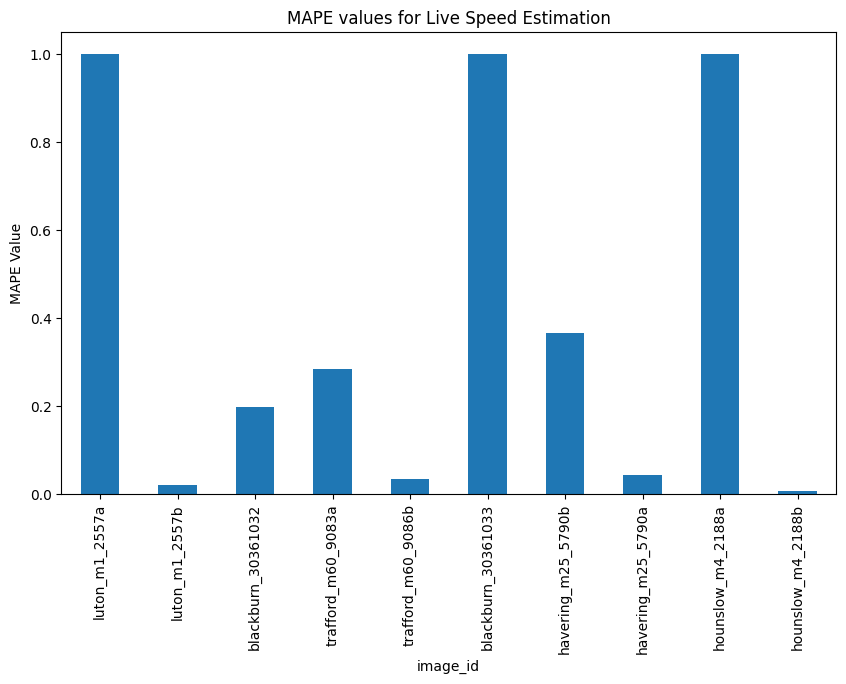

In [ ]:
# plot the data
ax = df_speed['MAPE'].plot(kind='bar', figsize=(10,6), title='MAPE values for Live Speed Estimation')
ax.set_ylabel('MAPE Value')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'live_speed_estimation.png', bbox_inches='tight')

plt.show()

## AADT and GHG 

In [ ]:
merged_df = pd.merge(df_aadt[['image_id', 'mean_aadt', 'true_aadt']], df_ghg[['image_id', 'mean_ghg', 'true_ghg']], on='image_id')

merged_df.head()

,image_id,mean_aadt,true_aadt,mean_ghg,true_ghg
0,luton_m1_2557a,74621.905,75141.0,26.683360,34.480488
1,luton_m1_2557b,74621.905,75141.0,26.683360,34.480488
2,hounslow_m4_2188b,79407.840,76791.0,76.189007,65.784938
3,hounslow_m4_2188a,79407.840,76791.0,76.189007,65.784938
4,trafford_m60_9083a,70331.285,68590.0,45.221642,96.466577


In [ ]:
merged_df['first_id'] = merged_df['image_id'].str.split('_').str[0]
merged_df = merged_df.drop_duplicates(subset='first_id', keep='first').drop(columns='first_id')
merged_df['image_id'] = merged_df['image_id'].str.split('_').str[0]

merged_df.head()

,image_id,mean_aadt,true_aadt,mean_ghg,true_ghg
0,luton,74621.905,75141.0,26.683360,34.480488
2,hounslow,79407.840,76791.0,76.189007,65.784938
4,trafford,70331.285,68590.0,45.221642,96.466577
6,havering,68451.860,76788.0,125.285393,161.286581
8,blackburn,39443.435,37300.0,33.172337,39.780264


In [ ]:
# scatter plot of mean_aadt vs. mean_ghg
fig = go.Figure()

# Define a list of colors
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink']

# Generate a unique color for each unique image_id
image_ids = merged_df['image_id'].unique()
color_mapping = {image_id: colors[i % len(colors)] for i, image_id in enumerate(image_ids)}

for image_id in image_ids:
    # Get the color value for the current image_id
    color_value = color_mapping[image_id]
    
    image_df = merged_df[merged_df['image_id'] == image_id]
    
    fig.add_trace(go.Scatter(
        x=image_df['mean_aadt'],
        y=image_df['mean_ghg'],
        mode='markers',
        marker={
            'size': 10,
            'color': [color_value] * len(image_df),
            'cmin': 0,
            'cmax': 1
        },
        name=image_id,
        text=image_df['image_id']
    ))
    
    fig.add_trace(go.Scatter(
        x=image_df['true_aadt'],
        y=image_df['true_ghg'],
        mode='markers',
        marker={
            'size': 10,
            'symbol': 'star',
            'color': [color_value] * len(image_df),
            'cmin': 0,
            'cmax': 1
        },
        name=image_id,
        text=image_df['image_id']
    ))
    

fig.add_trace(go.Scatter(
    x=merged_df['mean_aadt'],
    y=np.polyval(np.polyfit(merged_df['mean_aadt'], merged_df['mean_ghg'], 1), merged_df['mean_aadt']),
    mode='lines',
    marker={
        'color': 'black'
    },
    name='Pred Line of Best Fit'
))

fig.add_trace(go.Scatter(
    x=merged_df['true_aadt'],
    y=np.polyval(np.polyfit(merged_df['true_aadt'], merged_df['true_ghg'], 1), merged_df['true_aadt']),
    mode='lines',
    marker={
        'color': 'black'
    },
    line={
        'dash': 'dash'
    },
    name='True Line of Best Fit'
))

fig.update_layout(
    title='Motorways AADT vs GHG Emissions for Chosen LAs',
    xaxis_title='Mean AADT',
    yaxis_title='Mean GHG',
    legend_title='Image ID',
    width=1000,
    height=800
)

# Save the plot as an image
file_path = os.path.join(PLOT_DIR, 'motorways_aadt_ghg_eval_'+MODE+'_plot.png')
fig.write_image(file_path)

fig.show()

## Different Statistics

In [ ]:
df_motorways_aadt_max_metrics = pd.read_csv(METRICS_DIR+'motorways_aadt_max_metrics.csv')
df_motorways_ghg_max_metrics = pd.read_csv(METRICS_DIR+'motorways_ghg_max_metrics.csv')

df_motorways_aadt_median_metrics = pd.read_csv(METRICS_DIR+'motorways_aadt_median_metrics.csv')
df_motorways_ghg_median_metrics = pd.read_csv(METRICS_DIR+'motorways_ghg_median_metrics.csv')

df_motorways_aadt_mean_metrics = pd.read_csv(METRICS_DIR+'motorways_aadt_mean_metrics.csv')
df_motorways_ghg_mean_metrics = pd.read_csv(METRICS_DIR+'motorways_ghg_mean_metrics.csv')

In [ ]:
# First, we'll merge the dataframes on the 'image_id' column
merged_df = pd.merge(df_motorways_aadt_max_metrics, df_motorways_aadt_median_metrics, on='image_id')
merged_df = pd.merge(merged_df, df_motorways_aadt_mean_metrics, on='image_id')

merged_df['first_id'] = merged_df['image_id'].str.split('_').str[0]
merged_df = merged_df.drop_duplicates(subset='first_id', keep='first').drop(columns='first_id')
merged_df['image_id'] = merged_df['image_id'].str.split('_').str[0]

merged_df.head()

,image_id,RMSE_x,MAPE_x,RMSE_y,MAPE_y,RMSE,MAPE
0,blackburn,2143.435,0.057465,2848.150,0.080609,653.295000,0.019065
2,havering,8336.140,0.108560,8350.475,0.125866,9450.200000,0.139076
4,hounslow,2616.840,0.034077,6204.760,0.121549,3267.093333,0.058782
6,luton,519.095,0.006908,397.660,0.005652,545.600000,0.007734
8,trafford,1741.285,0.025387,2752.140,0.045628,1991.918333,0.032833


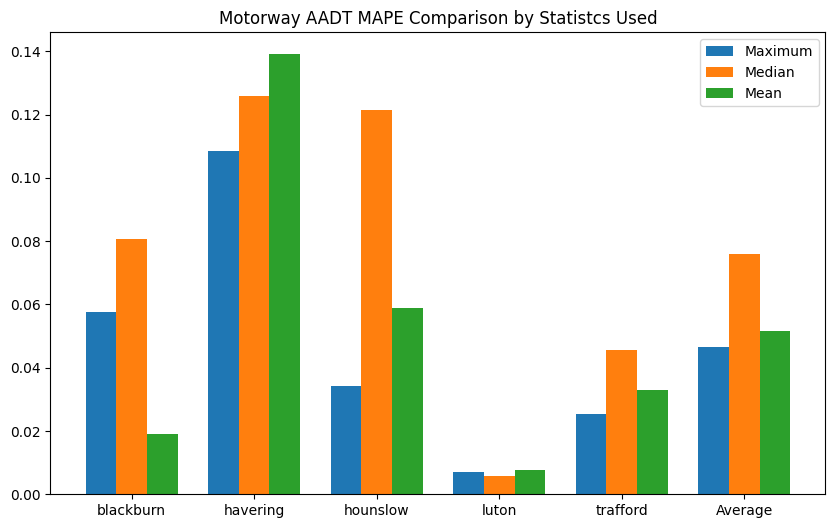

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars and the positions of the bars for each dataframe
bar_width = 0.25
x1 = np.arange(len(merged_df))
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

# Create another figure with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# And another bar graph for MAPE
plt.bar(x1, merged_df['MAPE_x'], width=bar_width, label='Maximum')
plt.bar(x2, merged_df['MAPE_y'], width=bar_width, label='Median')
plt.bar(x3, merged_df['MAPE'], width=bar_width, label='Mean')
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df['image_id'])
plt.legend()
plt.title('Motorway AADT MAPE Comparison by Statistcs Used')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'stats_used_aadt_mape_comparison.png', bbox_inches='tight')

plt.show()

In [ ]:
# First, we'll merge the dataframes on the 'image_id' column
merged_df = pd.merge(df_motorways_ghg_max_metrics, df_motorways_ghg_median_metrics, on='image_id')
merged_df = pd.merge(merged_df, df_motorways_ghg_mean_metrics, on='image_id')

merged_df['first_id'] = merged_df['image_id'].str.split('_').str[0]
merged_df = merged_df.drop_duplicates(subset='first_id', keep='first').drop(columns='first_id')
merged_df['image_id'] = merged_df['image_id'].str.split('_').str[0]

merged_df.head()

,image_id,RMSE_x,MAPE_x,RMSE_y,MAPE_y,RMSE,MAPE
0,blackburn,6.607927,0.166111,8.341949,0.209701,7.792243,0.195882
2,havering,36.001188,0.223213,41.574029,0.257765,39.945096,0.247665
4,hounslow,10.404070,0.158153,6.136709,0.093284,4.604368,0.069991
6,luton,7.797128,0.226132,8.124777,0.235634,7.810539,0.226521
8,trafford,51.244935,0.531220,54.576975,0.565760,54.305571,0.562947


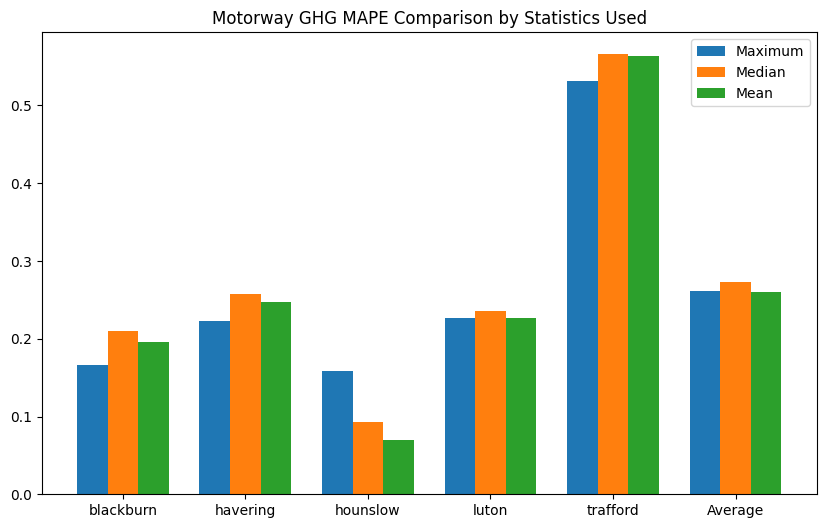

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars and the positions of the bars for each dataframe
bar_width = 0.25
x1 = np.arange(len(merged_df))
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

# Create another figure with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# And another bar graph for MAPE
plt.bar(x1, merged_df['MAPE_x'], width=bar_width, label='Maximum')
plt.bar(x2, merged_df['MAPE_y'], width=bar_width, label='Median')
plt.bar(x3, merged_df['MAPE'], width=bar_width, label='Mean')
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df['image_id'])
plt.legend()
plt.title('Motorway GHG MAPE Comparison by Statistics Used')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'stats_used_ghg_mape_comparison.png', bbox_inches='tight')

plt.show()

## All Road Types

### Max

In [ ]:
df_motorways_aadt_metrics = pd.read_csv(METRICS_DIR+'motorways_aadt_max_metrics.csv')
df_motorways_ghg_metrics = pd.read_csv(METRICS_DIR+'motorways_ghg_max_metrics.csv')

df_aroads_aadt_metrics = pd.read_csv('/content/drive/MyDrive/Spatial_Finance_Transport/ARoads/data/predicted/results/metrics/a_roads_aadt_max_metrics.csv')
df_aroads_ghg_metrics = pd.read_csv('/content/drive/MyDrive/Spatial_Finance_Transport/ARoads/data/predicted/results/metrics/a_roads_ghg_max_metrics.csv')

df_minor_roads_aadt_metrics = pd.read_csv('/content/drive/MyDrive/Spatial_Finance_Transport/minorRoads/data/predicted/results/metrics/minor_roads_aadt_max_metrics.csv')
df_minor_roads_ghg_metrics = pd.read_csv('/content/drive/MyDrive/Spatial_Finance_Transport/minorRoads/data/predicted/results/metrics/minor_roads_ghg_max_metrics.csv')

df_motorways_aadt_metrics

,image_id,RMSE,MAPE
0,blackburn_30361032,2143.435,0.057465
1,blackburn_30361033,2143.435,0.057465
2,havering_m25_5790a,8336.140,0.108560
3,havering_m25_5790b,8336.140,0.108560
4,hounslow_m4_2188a,2616.840,0.034077
5,hounslow_m4_2188b,2616.840,0.034077
6,luton_m1_2557a,519.095,0.006908
7,luton_m1_2557b,519.095,0.006908
8,trafford_m60_9083a,1741.285,0.025387
9,trafford_m60_9086b,1741.285,0.025387


In [ ]:
# First, we'll merge the dataframes on the 'image_id' column
merged_df = pd.merge(df_motorways_aadt_metrics, df_aroads_aadt_metrics, on='image_id')
merged_df = pd.merge(merged_df, df_minor_roads_aadt_metrics, on='image_id')

merged_df['first_id'] = merged_df['image_id'].str.split('_').str[0]
merged_df = merged_df.drop_duplicates(subset='first_id', keep='first').drop(columns='first_id')
merged_df['image_id'] = merged_df['image_id'].str.split('_').str[0]

merged_df.head()

,image_id,RMSE_x,MAPE_x,RMSE_y,MAPE_y,RMSE,MAPE
0,blackburn,2143.435,0.057465,3533.555,0.196015,65.700,0.090809
2,havering,8336.140,0.108560,5442.070,0.108265,2450.990,0.696403
4,hounslow,2616.840,0.034077,4253.410,0.075240,1789.920,0.581709
6,luton,519.095,0.006908,2131.900,0.083679,150.540,0.344485
8,trafford,1741.285,0.025387,1710.830,0.049928,311.045,0.239173


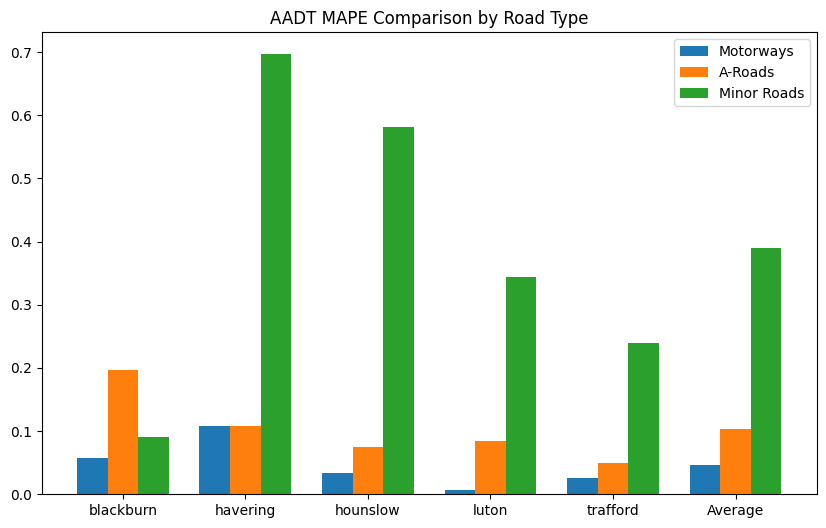

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars and the positions of the bars for each dataframe
bar_width = 0.25
x1 = np.arange(len(merged_df))
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

# Create another figure with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# And another bar graph for MAPE
plt.bar(x1, merged_df['MAPE_x'], width=bar_width, label='Motorways')
plt.bar(x2, merged_df['MAPE_y'], width=bar_width, label='A-Roads')
plt.bar(x3, merged_df['MAPE'], width=bar_width, label='Minor Roads')
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df['image_id'])
plt.legend()
plt.title('AADT MAPE Comparison by Road Type')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'aadt_mape_comparison.png', bbox_inches='tight')

plt.show()

In [ ]:
# First, we'll merge the dataframes on the 'image_id' column
merged_df = pd.merge(df_motorways_ghg_metrics, df_aroads_ghg_metrics, on='image_id')
merged_df = pd.merge(merged_df, df_minor_roads_ghg_metrics, on='image_id')

merged_df['first_id'] = merged_df['image_id'].str.split('_').str[0]
merged_df = merged_df.drop_duplicates(subset='first_id', keep='first').drop(columns='first_id')
merged_df['image_id'] = merged_df['image_id'].str.split('_').str[0]

merged_df.head()

,image_id,RMSE_x,MAPE_x,RMSE_y,MAPE_y,RMSE,MAPE
0,blackburn,6.607927,0.166111,14.788135,0.269541,108.976407,1.377361
2,havering,36.001188,0.223213,12.231751,0.081982,99.478795,0.739929
4,hounslow,10.404070,0.158153,22.595486,0.122831,37.119388,0.241240
6,luton,7.797128,0.226132,18.032066,0.326861,20.598689,0.153258
8,trafford,51.244935,0.531220,14.862344,0.158112,109.806475,0.547064


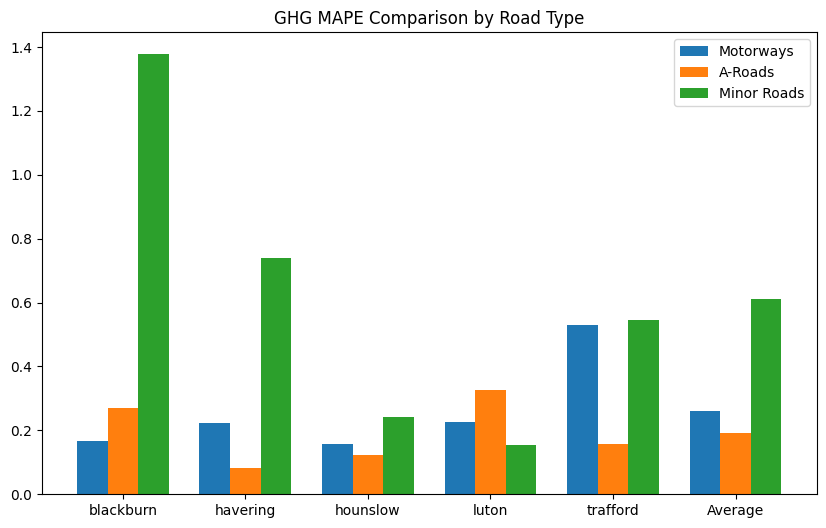

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars and the positions of the bars for each dataframe
bar_width = 0.25
x1 = np.arange(len(merged_df))
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

# Create another figure with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# And another bar graph for MAPE
plt.bar(x1, merged_df['MAPE_x'], width=bar_width, label='Motorways')
plt.bar(x2, merged_df['MAPE_y'], width=bar_width, label='A-Roads')
plt.bar(x3, merged_df['MAPE'], width=bar_width, label='Minor Roads')
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df['image_id'])
plt.legend()
plt.title('GHG MAPE Comparison by Road Type')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'ghg_mape_comparison.png', bbox_inches='tight')

plt.show()

## No Vehicle Type

In [ ]:
df_motorways_ghg_max_metrics = pd.read_csv(METRICS_DIR+'motorways_ghg_max_metrics.csv')
df_motorways_ghg_no_vehicle_type_metrics = pd.read_csv(METRICS_DIR+'motorways_ghg_no_vehicle_type_metrics.csv')

In [ ]:
# First, we'll merge the dataframes on the 'image_id' column
merged_df = pd.merge(df_motorways_ghg_max_metrics, df_motorways_ghg_no_vehicle_type_metrics, on='image_id')

merged_df['first_id'] = merged_df['image_id'].str.split('_').str[0]
merged_df = merged_df.drop_duplicates(subset='first_id', keep='first').drop(columns='first_id')
merged_df['image_id'] = merged_df['image_id'].str.split('_').str[0]

merged_df.head()

,image_id,RMSE_x,MAPE_x,RMSE_y,MAPE_y
0,blackburn,6.607927,0.166111,8.329122,0.209378
2,havering,36.001188,0.223213,32.751439,0.203064
4,hounslow,10.404070,0.158153,6.660053,0.101240
6,luton,7.797128,0.226132,6.611520,0.191747
8,trafford,51.244935,0.531220,45.715201,0.473897


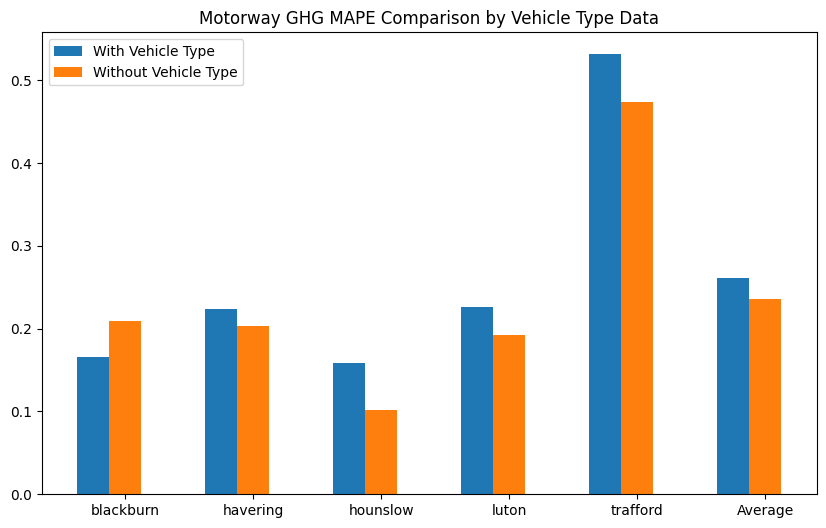

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars and the positions of the bars for each dataframe
bar_width = 0.25
x1 = np.arange(len(merged_df))
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

# Create another figure with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# And another bar graph for MAPE
plt.bar(x1, merged_df['MAPE_x'], width=bar_width, label='With Vehicle Type')
plt.bar(x2, merged_df['MAPE_y'], width=bar_width, label='Without Vehicle Type')
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df['image_id'])
plt.legend()
plt.title('Motorway GHG MAPE Comparison by Vehicle Type Data')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'no_vehicle_type_ghg_mape_comparison.png', bbox_inches='tight')

plt.show()

## No Speed Data

In [ ]:
df_traffic_count_metrics = pd.read_csv(METRICS_DIR+'traffic_count_max_metrics.csv')
df_traffic_count_no_speed_data_metrics = pd.read_csv(METRICS_DIR+'traffic_count_no_speed_data_metrics.csv')

In [ ]:
# First, we'll merge the dataframes on the 'image_id' column
merged_df = pd.merge(df_traffic_count_metrics, df_traffic_count_no_speed_data_metrics, on='image_id')

# drop rows with no speed estimate
merged_df = merged_df.drop(merged_df.loc[merged_df['MAPE_y'] == 1.00].index)

merged_df.head()

,Unnamed: 0.1_x,Unnamed: 0_x,Total_x,Small_x,Medium_x,Large_x,Very Large_x,image_id,Total_N15_x,Small_N15_x,...,Medium_N15_y,Large_N15_y,Very Large_N15_y,0-520cm_y,521-660cm_y,661-1160cm_y,1160+cm_y,Total Volume_y,RMSE_y,MAPE_y
0,0,0.0,38.0,4.0,13.0,16.0,5.0,blackburn_30361032,408.940397,43.046358,...,166.581391,205.023251,64.069766,436.0,13.0,10.0,7.0,466.0,20.930221,0.044915
1,1,0.0,222.0,23.0,29.0,96.0,74.0,havering_m25_5790a,572.258592,59.288052,...,78.123994,258.617360,199.350882,801.0,104.0,89.0,182.0,1176.0,577.947355,0.491452
2,2,0.0,86.0,10.0,19.0,34.0,23.0,hounslow_m4_2188b,812.500000,94.476744,...,179.904194,321.933822,217.778762,523.0,247.0,9.0,9.0,788.0,26.303196,0.033380
3,3,0.0,23.0,3.0,9.0,8.0,3.0,trafford_m60_9083a,370.432692,48.317308,...,184.362677,163.877935,61.454226,645.0,257.0,36.0,8.0,946.0,474.850937,0.501957
5,5,0.0,413.0,48.0,47.0,194.0,124.0,havering_m25_5790b,1064.607201,123.731588,...,165.724920,684.056052,437.231703,545.0,248.0,117.0,158.0,1068.0,388.263657,0.363543


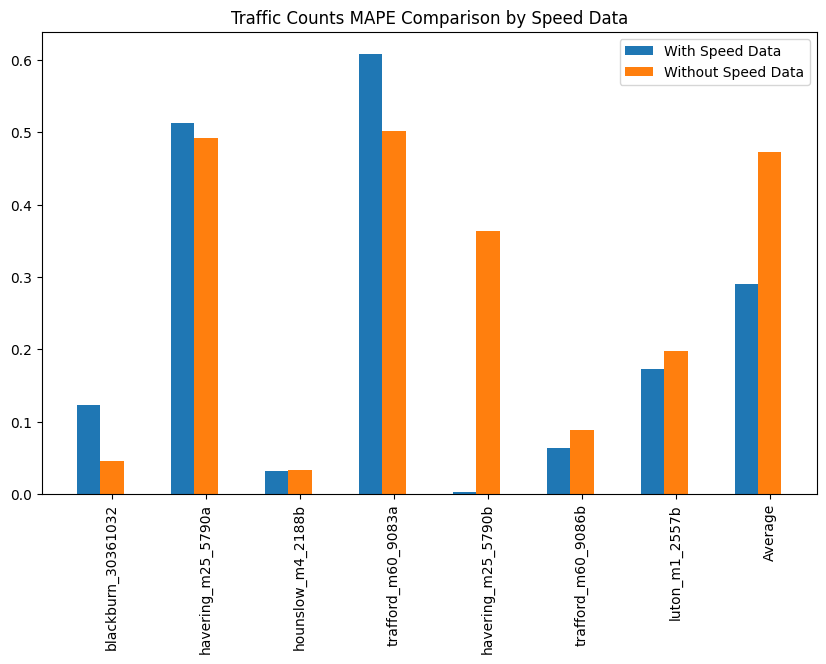

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars and the positions of the bars for each dataframe
bar_width = 0.25
x1 = np.arange(len(merged_df))
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

# Create another figure with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# And another bar graph for MAPE
plt.bar(x1, merged_df['MAPE_x'], width=bar_width, label='With Speed Data')
plt.bar(x2, merged_df['MAPE_y'], width=bar_width, label='Without Speed Data')
# Rotate the x-tick labels by 90 degrees to prevent overlapping
plt.xticks([r + bar_width for r in range(len(merged_df))], merged_df['image_id'], rotation=90)
plt.legend()
plt.title('Traffic Counts MAPE Comparison by Speed Data')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'no_speed_data_mape_comparison.png', bbox_inches='tight')

plt.show()

## YOLOv5 Results

In [ ]:
plot_results(YOLOV5_RESULTS_DIR, dir='')

## AADT Evaluation by Vehicle Type

In [15]:
df_aadt = pd.DataFrame()

for df_true_aadt in df_true_aadt_list:

  la_name = df_true_aadt.iloc[0]['Local Authority']

  true_aadt = df_true_aadt.loc[df_true_aadt['year'] == 2018]['all_motor_vehicles'].values
  true_cars_and_taxis = df_true_aadt.loc[df_true_aadt['year'] == 2018]['cars_and_taxis'].values
  true_buses_and_coaches = df_true_aadt.loc[df_true_aadt['year'] == 2018]['buses_and_coaches'].values
  true_lgvs = df_true_aadt.loc[df_true_aadt['year'] == 2018]['lgvs'].values
  true_all_hgvs = df_true_aadt.loc[df_true_aadt['year'] == 2018]['all_hgvs'].values

  for df_pred_aadt in df_pred_aadt_list:

    image_id = df_pred_aadt.iloc[0]['image_id']

    if match_before_underscore_or_space(la_name.lower(), image_id):

      print("found match for: {}".format(image_id))

      df_pred_aadt['true_aadt'] = true_aadt
      df_pred_aadt['true_cars_and_taxis'] = true_cars_and_taxis
      df_pred_aadt['true_buses_and_coaches'] = true_buses_and_coaches
      df_pred_aadt['true_lgvs'] = true_lgvs
      df_pred_aadt['true_all_hgvs'] = true_all_hgvs

      df_aadt = pd.concat([df_aadt, df_pred_aadt], ignore_index=True)

df_aadt

found match for: luton_m1_2557a
found match for: luton_m1_2557b
found match for: hounslow_m4_2188b
found match for: hounslow_m4_2188a
found match for: trafford_m60_9083a
found match for: trafford_m60_9086b
found match for: havering_m25_5790b
found match for: havering_m25_5790a
found match for: blackburn_30361032
found match for: blackburn_30361033


,image_id,aadt,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,mean_aadt,true_aadt,true_cars_and_taxis,true_buses_and_coaches,true_lgvs,true_all_hgvs
0,luton_m1_2557a,74024.92,59869.51,0.00,12616.99,11972.86,74621.905,75141.0,51417.0,283.0,12304.0,11496.0
1,luton_m1_2557b,75218.89,60956.58,0.00,12784.78,12131.16,74621.905,75141.0,51417.0,283.0,12304.0,11496.0
2,hounslow_m4_2188b,84389.18,74569.90,696.55,12275.62,3413.69,79407.840,76791.0,61545.0,550.0,11171.0,3104.0
3,hounslow_m4_2188a,74426.50,65780.04,566.55,10742.81,2960.29,79407.840,76791.0,61545.0,550.0,11171.0,3104.0
4,trafford_m60_9083a,67699.96,58963.17,0.00,9586.75,4632.44,70331.285,68590.0,55636.0,111.0,9087.0,3880.0
5,trafford_m60_9086b,72962.61,63733.99,0.00,10346.91,5024.68,70331.285,68590.0,55636.0,111.0,9087.0,3880.0
6,havering_m25_5790b,69331.22,50736.84,0.00,15641.17,13648.43,68451.860,76788.0,47141.0,157.0,16594.0,14148.0
7,havering_m25_5790a,67572.50,50244.58,0.00,15350.79,13434.31,68451.860,76788.0,47141.0,157.0,16594.0,14148.0
8,blackburn_30361032,39694.92,31378.50,0.00,6313.20,2704.20,39443.435,37300.0,28626.0,74.0,6197.0,2526.0
9,blackburn_30361033,39191.95,30868.02,0.00,6272.99,2681.64,39443.435,37300.0,28626.0,74.0,6197.0,2526.0


<ipython-input-28-fa5c904576d6>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mape_df = mape_df.append(avg_mape, ignore_index=True)


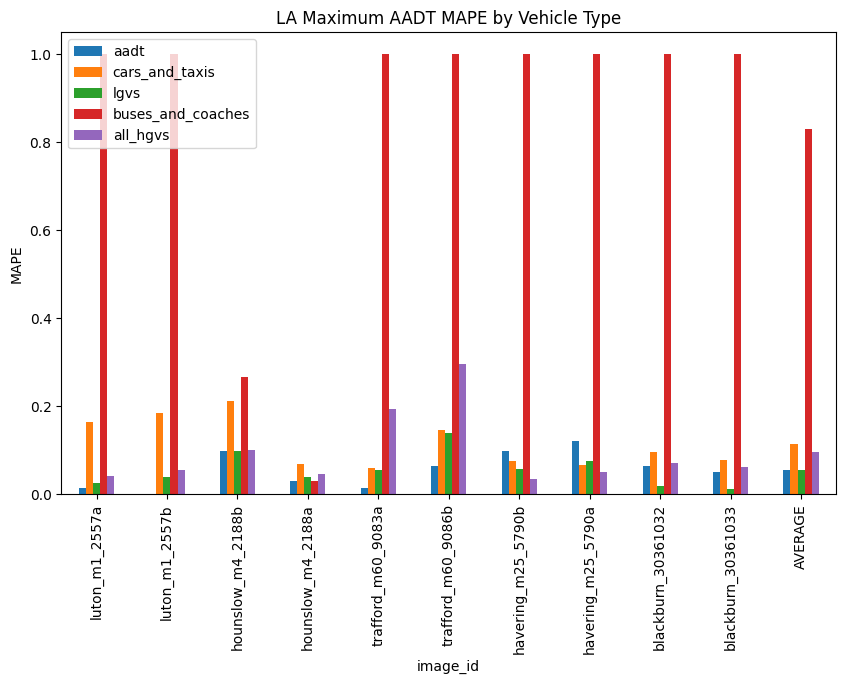

In [28]:
# Define a function to calculate MAPE
def mape(actual, predicted):
    return (abs(actual - predicted) / actual)

# Calculate MAPE for each column
mape_aadt = mape(df_aadt['true_aadt'], df_aadt['aadt'])
mape_cars_and_taxis = mape(df_aadt['true_cars_and_taxis'], df_aadt['cars_and_taxis'])
mape_buses_and_coaches = mape(df_aadt['true_buses_and_coaches'], df_aadt['buses_and_coaches'])
mape_lgvs = mape(df_aadt['true_lgvs'], df_aadt['lgvs'])
mape_all_hgvs = mape(df_aadt['true_all_hgvs'], df_aadt['all_hgvs'])

# Create a new DataFrame to store the MAPE values
mape_df = pd.DataFrame({
    'image_id': df_aadt['image_id'],
    'aadt': mape_aadt,
    'cars_and_taxis': mape_cars_and_taxis,
    'lgvs': mape_lgvs,
    'buses_and_coaches': mape_buses_and_coaches,
    'all_hgvs': mape_all_hgvs
})

# Calculate the average MAPE for each column
avg_mape = pd.DataFrame({
    'image_id': ['AVERAGE'],
    'aadt': [mape_df['aadt'].mean()],
    'cars_and_taxis': [mape_df['cars_and_taxis'].mean()],
    'lgvs': [mape_df['lgvs'].mean()],
    'buses_and_coaches': [mape_df['buses_and_coaches'].mean()],
    'all_hgvs': [mape_df['all_hgvs'].mean()]
})

# Append the average MAPE row to the DataFrame
mape_df = mape_df.append(avg_mape, ignore_index=True)

# Plot the results as a bar chart
mape_df.plot(x='image_id', kind='bar', figsize=(10, 6))
plt.title('LA Maximum AADT MAPE by Vehicle Type')
plt.xlabel('image_id')
plt.ylabel('MAPE')

# Save the figure to a file
plt.savefig(ADMIN_DIR+'aadt_mape_by_vehicle_type_comparison.png', bbox_inches='tight')


plt.show()